# Shell Element Responses (Pyvista)

In [1]:
import openseespy.opensees as ops

import opstool as opst
import opstool.vis.pyvista as opsvis


## Model and gravity load

In [2]:
opst.load_ops_examples("Shell3D")

ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
_ = opst.pre.gen_grav_load(direction="Z", factor=-9810)

The original Tcl file comes from http://www.dinochen.com/, and the Python version is converted by opstool.tcl2py().


In [3]:
on_notebook = True
jupyter_backend = "static"

# on_notebook = False
# jupyter_backend = None

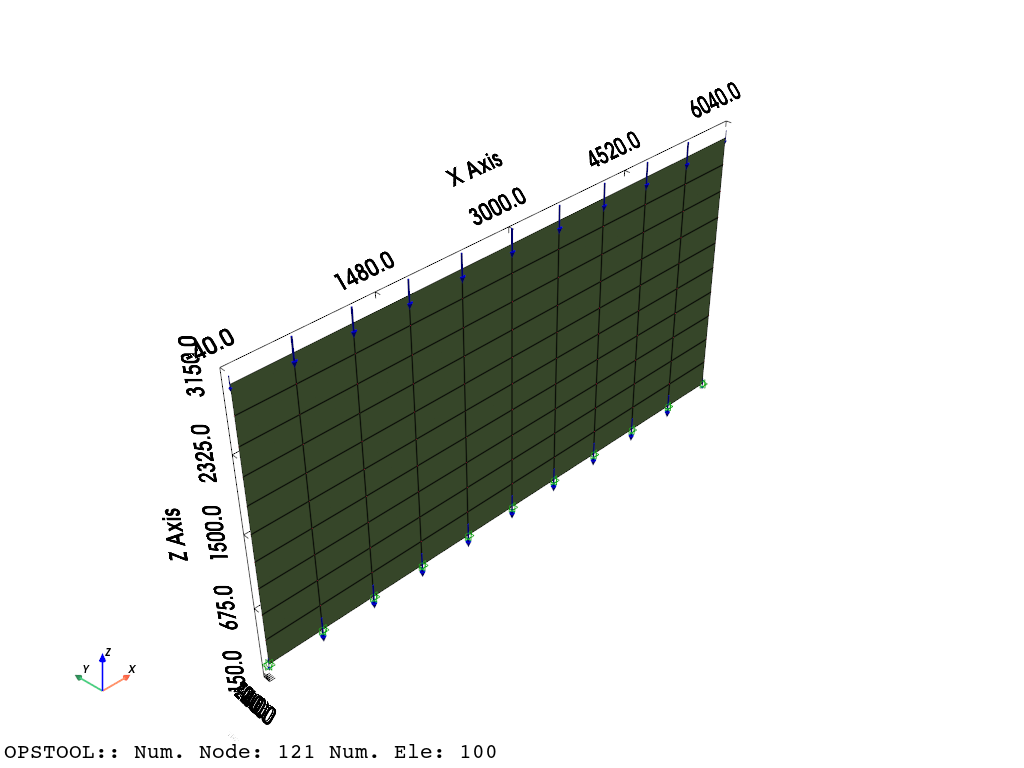

In [4]:
opsvis.set_plot_props(point_size=0, line_width=3, notebook=on_notebook)  # notebook=False for practical use
fig = opsvis.plot_model(show_nodal_loads=True, show_ele_loads=True, show_outline=True)
fig.show(jupyter_backend=jupyter_backend)
# fig.show()

## Gravity analysis

In [5]:
ops.constraints("Transformation")
ops.numberer("RCM")
ops.system("BandGeneral")
ops.test("NormDispIncr", 1.0e-8, 6, 2)
ops.algorithm("Linear")
ops.integrator("LoadControl", 0.1)
ops.analysis("Static")

Save the responses

In [6]:
ODB = opst.post.CreateODB(
    odb_tag=1,
    project_gauss_to_nodes="copy",  # project gauss point responses to nodes, optional ["copy", "average", "extrapolate"]
)
for _ in range(10):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL ::  All responses data with _odb_tag = 1 saved in .opstool.output/RespStepData-1.nc!

## Visualize the results

Nodal responses, ``project_gauss_to_nodes`` needs to be set to "copy", "average", or "extrapolate" when creating the ODB

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

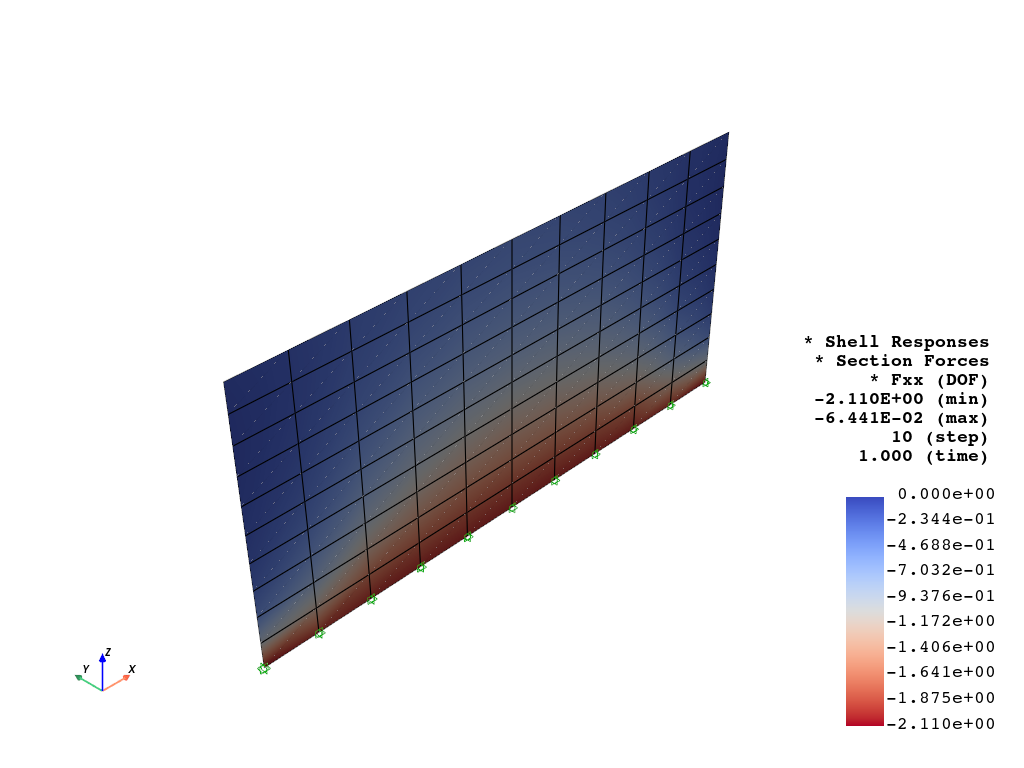

In [7]:
opsvis.set_plot_props(cmap="coolwarm_r", show_mesh_edges=True, notebook=on_notebook)

fig = opsvis.plot_unstruct_responses(
    odb_tag=1,
    slides=False,
    step="absMax",
    ele_type="Shell",
    resp_type="sectionForcesAtNodes",  # nodal response, "AtNodes"
    resp_dof="FXX",
)
fig.show(jupyter_backend=jupyter_backend)
# fig.show()

Display the responses at each element, all gauss points will be averaged to the element level.

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

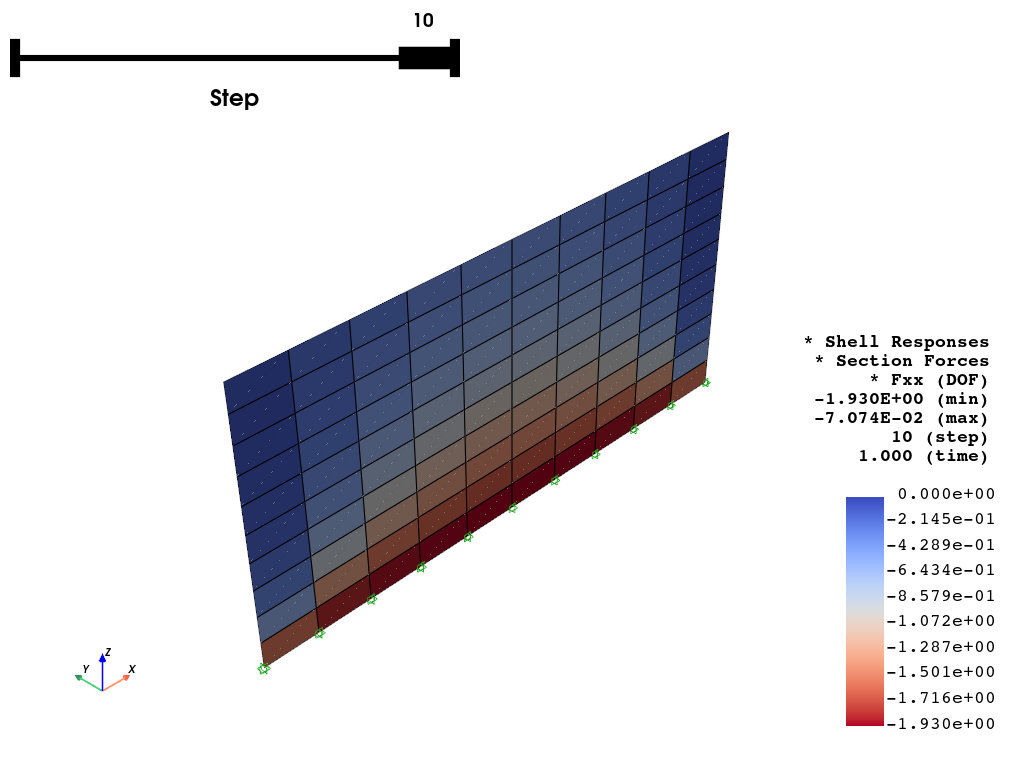

In [8]:
fig = opsvis.plot_unstruct_responses(
    odb_tag=1,
    slides=True,
    ele_type="Shell",
    resp_type="sectionForces",  # element response, "AtGaussPoints", will be averaged to each element
    resp_dof="FXX",
)
fig.show(jupyter_backend=jupyter_backend)

Fiber point stress can be plotted as well, but it requires a ``shell_fiber_loc`` to be assigned.

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

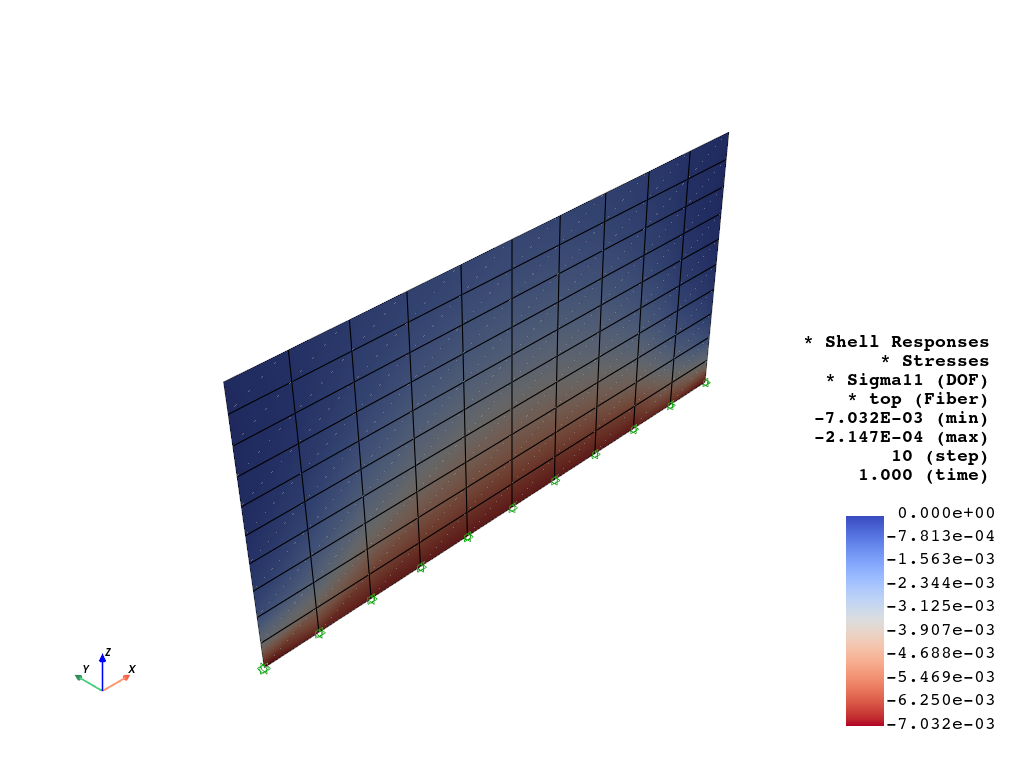

In [9]:
fig = opsvis.plot_unstruct_responses(
    odb_tag=1,
    slides=False,
    step="absMax",
    ele_type="Shell",
    resp_type="StressesAtNodes",  # nodal stress response, "AtNodes"
    resp_dof="sigma11",  # sigma11, sigma22, sigma12, sigma13, sigma23
    shell_fiber_loc="top",  # shell_fiber_loc can be "top", "bottom", or "mid" for shell elements, also int
)
fig.show(jupyter_backend=jupyter_backend)

## Interacting with Pyvista

Since version 1.0.18, opstool provides a function ``get_unstruct_responses_dataset`` that returns a pyvista [UnstructuredGrid](https://docs.pyvista.org/api/core/_autosummary/pyvista.unstructuredgrid#pyvista.UnstructuredGrid) so that you can take advantage of all the functionality on it.

In [10]:
import pyvista as pv

In [11]:
grid = opsvis.get_unstruct_responses_dataset(
    odb_tag=1,
    step="absMax",
    ele_type="Shell",
    resp_type="StressesAtNodes",  # nodal stress response, "AtNodes"
    resp_dof="sigma11",  # sigma11, sigma22, sigma12, sigma13, sigma23
    shell_fiber_loc="top",  # shell_fiber_loc can be "top", "bottom", or "mid" for shell elements, also int
)

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

In [12]:
print(grid)
print("--" * 20)
print(grid.active_scalars_name)

UnstructuredGrid (0x1888f77eaa0)
  N Cells:    100
  N Points:   121
  X Bounds:   0.000e+00, 6.000e+03
  Y Bounds:   0.000e+00, 0.000e+00
  Z Bounds:   0.000e+00, 3.000e+03
  N Arrays:   1
----------------------------------------
StressesAtNodes


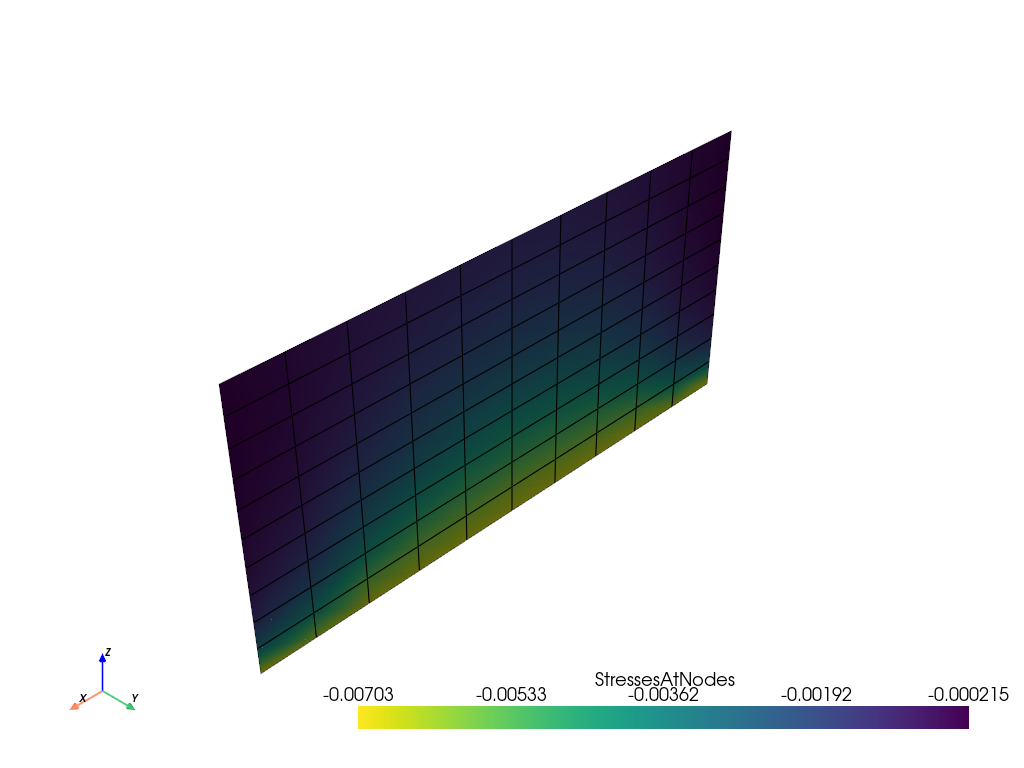

In [13]:
grid.plot(jupyter_backend=jupyter_backend, show_edges=True, cmap="viridis_r", show_scalar_bar=True)

### Plot Over Line

In [14]:
grid.bounds

(0.0, 6000.0, 0.0, 0.0, 0.0, 3000.0)

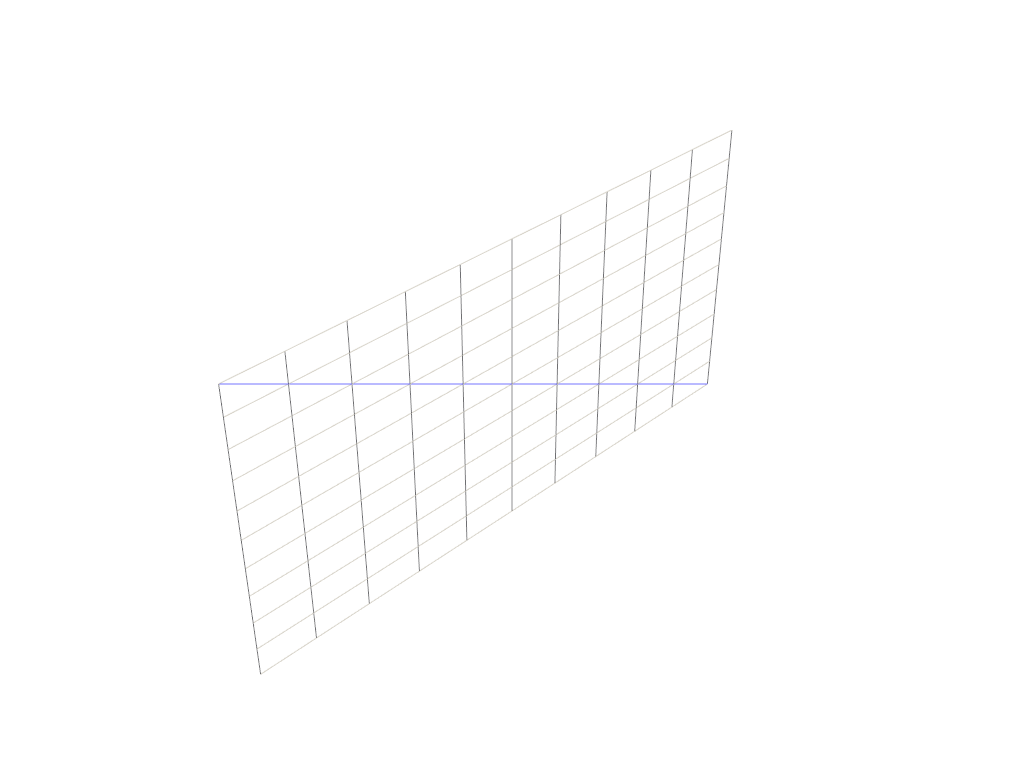

In [15]:
a = [0, 0, 0]
b = [6000, 0, 3000]  # A line from (0, 0, 0) to (0, 0, 1)

# Preview how this line intersects this mesh
line = pv.Line(a, b)

p = pv.Plotter()
p.add_mesh(grid, style="wireframe", color="w")
p.add_mesh(line, color="b")
p.show(jupyter_backend=jupyter_backend)

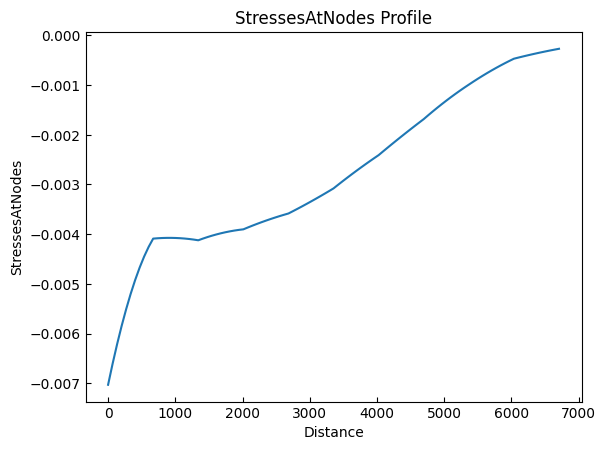

In [16]:
grid.plot_over_line(a, b)

More details can be found in the [PyVista Examples](https://docs.pyvista.org/examples/).